In [1]:
import cedalion
import cedalion.models.glm.basis_functions as bf
import cedalion.models.glm.design_matrix as dm

import cedalion.dataclasses as cdc

import matplotlib.pyplot as p
import numpy as np
import xarray as xr
import matplotlib.pyplot as p
import cedalion.datasets

units = cedalion.units

xr.set_options(display_expand_data=False)

In [7]:
# dummy time series
fs = 8.0
ts = cdc.build_timeseries(
    np.random.random((100, 1, 2)),
    dims=["time", "channel", "chromo"],
    time=np.arange(100) / fs,
    channel=["S1D1"],
    value_units=units.uM,
    time_units=units.s,
    other_coords={'chromo' : ["HbO", "HbR"]}
)
display(ts)

<xarray.DataArray (time: 100, channel: 1, chromo: 2)> Size: 2kB
[µM] 0.5544 0.04519 0.4603 0.4991 0.2354 ... 0.4091 0.09743 0.7676 0.3888 0.7589
Coordinates:
  * time     (time) float64 800B 0.0 0.125 0.25 0.375 ... 12.0 12.12 12.25 12.38
    samples  (time) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * channel  (channel) <U4 16B 'S1D1'
  * chromo   (chromo) <U3 24B 'HbO' 'HbR'

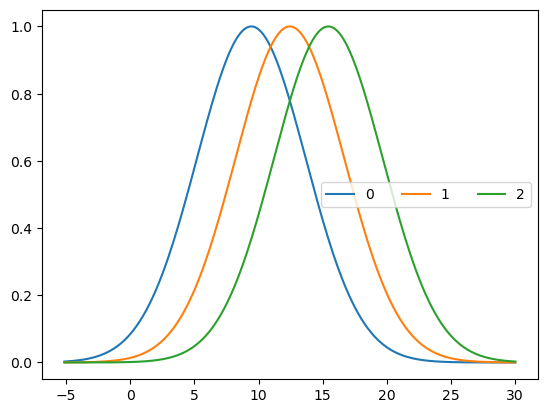

In [3]:
basis = bf.GaussianKernels(
    t_pre=5 * units.s,
    t_post=30 * units.s,
    t_delta=3 * units.s,
    t_std=3 * units.s,
)
hrf = basis(ts)

p.figure()
for i_comp, comp in enumerate(hrf.component.values):
    p.plot(hrf.time, hrf[:, i_comp], label=comp)
p.legend(ncols=3)

<xarray.DataArray (time: 98, component: 1, chromo: 2)> Size: 2kB
0.0 0.0 0.0 0.0 0.0 0.0 ... 7.789e-06 8.836e-08 4.894e-06 5.155e-08 3.05e-06
Coordinates:
  * time     (time) float64 784B 0.0 0.125 0.25 0.375 ... 11.75 11.88 12.0 12.12
  * chromo   (chromo) <U3 24B 'HbO' 'HbR'
Dimensions without coordinates: component

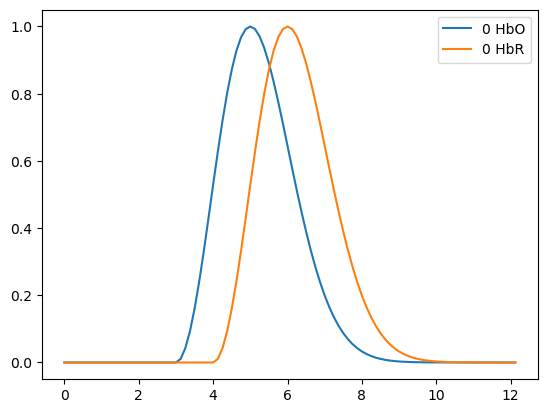

In [8]:
basis = bf.Gamma(
    tau={"HbO": 3 * units.s, "HbR": 4 * units.s},
    sigma=2 * units.s,
    T=0 * units.s,
)
hrf = basis(ts)
display(hrf)
p.figure()
for i_comp, comp in enumerate(hrf.component.values):
    for i_chromo, chromo in enumerate(hrf.chromo.values):
        p.plot(hrf.time, hrf[:, i_comp, i_chromo], label=f"{comp} {chromo}")

p.legend()

<xarray.DataArray (time: 106, component: 1, chromo: 2)> Size: 2kB
0.0 0.0 0.0005512 0.0005512 0.00273 ... 4.08e-07 4.08e-07 2.491e-07 2.491e-07
Coordinates:
  * time     (time) float64 848B 0.0 0.125 0.25 0.375 ... 12.75 12.88 13.0 13.12
  * chromo   (chromo) <U3 24B 'HbO' 'HbR'
Dimensions without coordinates: component

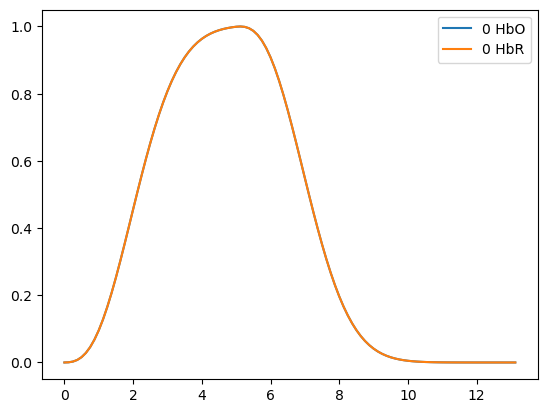

In [12]:
basis = bf.Gamma(
    tau=0 * units.s,
    sigma=2 * units.s,
    T=5 * units.s,
)
hrf = basis(ts)
display(hrf)
p.figure()
for i_comp, comp in enumerate(hrf.component.values):
    for i_chromo, chromo in enumerate(hrf.chromo.values):
        p.plot(hrf.time, hrf[:, i_comp, i_chromo], label=f"{comp} {chromo}")

p.legend()

In [6]:
elements = cedalion.datasets.get_fingertapping()
amp = elements[0].data[0]
geo3d = elements[0].geo3d
stim = elements[0].stim
stim.cd.rename_events({"1.0": "control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"})

dpf = xr.DataArray([6, 6], dims="wavelength", coords={"wavelength" : amp.wavelength})
od = cedalion.nirs.int2od(amp)
conc = cedalion.nirs.od2conc(od, geo3d, dpf, "prahl")
conc.time.attrs["units"] = "s"

sel_stim = stim[stim.trial_type.isin(["Tapping/Left", "Tapping/Right"])]
sel_stim["duration"] = 20

AttributeError: 'DataArray' object has no attribute 'geo3d'

In [ ]:
sel_stim.head(5)

In [ ]:
regressors = dm.make_hrf_regressors(
    conc,
    sel_stim,
    basis_function=bf.GaussianKernels(
        t_pre=5 * units.s,
        t_post=30 * units.s,
        t_delta=1.5 * units.s,
        t_std=1.5 * units.s,
    ),
)
display(regressors)

p.figure()
for i_reg, reg in enumerate(regressors.regressor.values):
    for i_chromo, chromo in enumerate(regressors.chromo.values):
        p.plot(regressors.time, regressors[:, i_reg, i_chromo], label=f"{comp} {chromo}")

for i in sel_stim.onset:
    p.axvline(i)

p.xlim(200,300)



In [ ]:
regressors = dm.make_hrf_regressors(
    conc,
    sel_stim,
    basis_function=bf.Gamma(
        tau={"HbO": 0 * units.s, "HbR": 0 * units.s},
        sigma=5 * units.s,
        T=0 * units.s,
    ),
)
display(regressors)

p.figure()
for reg in regressors.regressor.values:
    for chromo in regressors.chromo.values:
        p.plot(
            regressors.time,
            regressors.sel(regressor=reg, chromo=chromo),
            label=f"{reg} {chromo}",
        )

for o, d in zip(sel_stim.onset, sel_stim.duration):
    p.axvline(o)
    p.axvline(o + d)

p.xlim(200, 300)
p.legend()